In [2]:
import os
import pandas as pd
import numpy as np
#import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.regularizers import l2
from keras.optimizers import Adam
import tensorflow as tf
from keras import layers
import keras
import utils

In [3]:
DATA_PATH = "/Users/mykola/MLHEP/Wiremind/"
raw_features = pd.read_csv(os.path.join(DATA_PATH, "ds_train.csv"))
all_features = utils.features_preparation(raw_features)
scaled_features = utils.features_scale(all_features)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[44189.0, 47836.0, 51640.0, 56415.0, 75985.0, 59877.0, 59768.0]


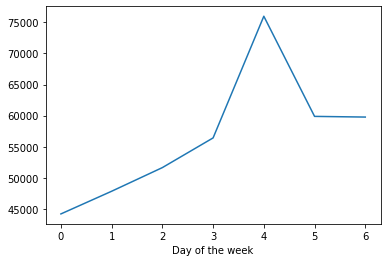

In [5]:
#the demand peaks on Friday
dem_weekday = [all_features[all_features.od_destination_time_weekday.eq(x)].demand.sum() for x in sorted(all_features.od_destination_time_weekday.unique())]
print(dem_weekday)
plt.plot(range(0,len(dem_weekday)),dem_weekday)
plt.xlabel('Day of the week')
plt.show()

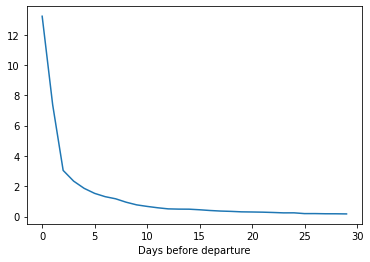

In [9]:
#The demand is concentrated mainly within one week before the departure date
dem_daysbefore = [ np.mean(all_features[all_features.days_before_departure.eq(x)].demand) for x in sorted(all_features.days_before_departure.unique())]
import matplotlib.pyplot as plt
plt.plot(range(0,len(dem_daysbefore)),dem_daysbefore)
plt.xlabel('Days before departure')
plt.show()

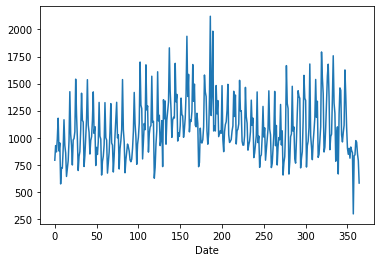

In [10]:
#Weekly oscillations are combined with seasonal demand oscillations of lower frequency
dem_date = [all_features[all_features.date_numerical.eq(x)].demand.sum() for x in sorted(all_features.date_numerical.unique())]
import matplotlib.pyplot as plt
plt.plot(range(0,len(dem_date)),dem_date)
plt.xlabel('Date')
plt.show()

In [93]:
train_part, validation = train_test_split(scaled_features, test_size=0.2, shuffle=True, random_state=2334)
print(train_part.shape)
print(validation.shape)
target = "demand"

(234120, 14)
(58530, 14)


In [94]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, bootstrap=True, n_jobs=-1)
rf.fit(train_part[utils.input_features], train_part.demand)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [95]:
rforest_prediction = np.array(rf.predict(validation.loc[:, utils.input_features].values),dtype=float)

In [78]:
print ("Features sorted by their score:")
key_features = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), utils.input_features), reverse=True)
print(key_features)
values =  sorted(np.around(rf.feature_importances_,4),reverse=True )
names = [x for _,x in key_features]


Features sorted by their score:
[(0.5251, 'days_before_departure'), (0.1423, 'od_destination_time_hourmin'), (0.0715, 'od_destination_time_weekday'), (0.0697, 'od_origin_time_hourmin'), (0.064, 'od_destination_time_day'), (0.0588, 'od_destination_time_week'), (0.0269, 'od_time_travel'), (0.0174, 'od_destination_time_month'), (0.0128, 'direction_bool'), (0.0115, 'current_price'), (0.0, 'unof_holiday'), (0.0, 'of_holiday')]


<Figure size 1440x720 with 0 Axes>

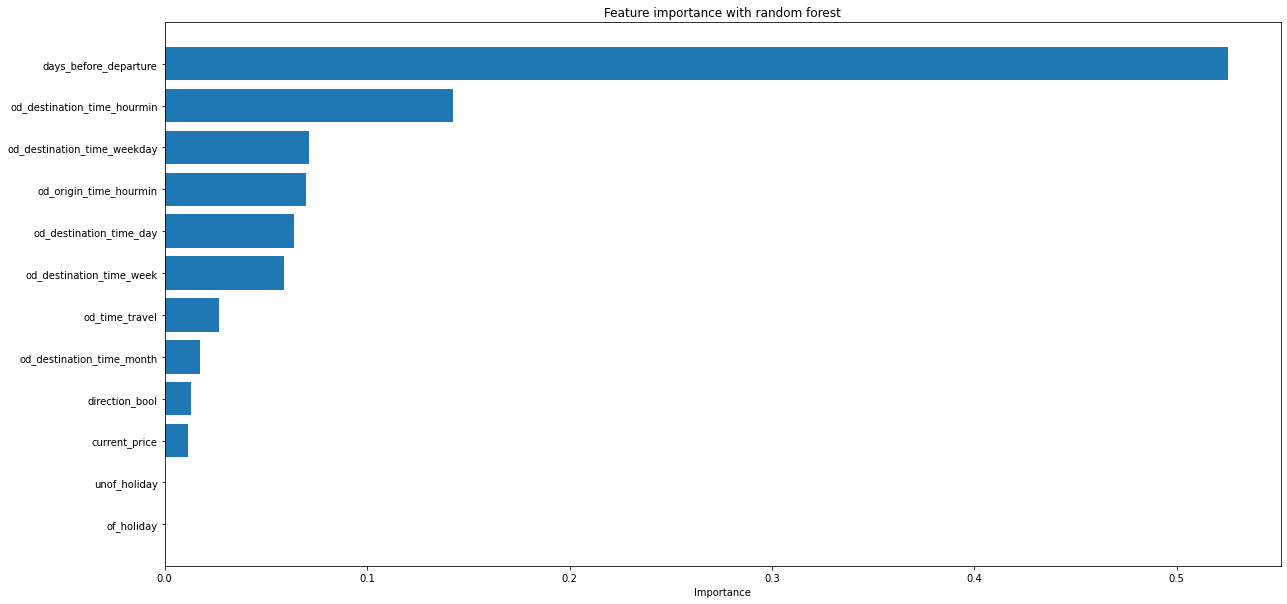

In [134]:
fig, ax = plt.subplots(figsize=(20,10))

y_pos = range(len(names))
ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)

ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Importance')
ax.set_title('Feature importance with random forest')

plt.show()


In [287]:
#Improrting feedforward neural network model and testing its prediction on the validation piece
from keras.models import load_model
import tensorlayer as tl

#model = load_model("/Users/mykola/MLHEP/Wiremind/NNmodels/weights.1143-0.77916.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":utils.r_square})
model = load_model("/Users/mykola/MLHEP/Wiremind/NNmodels/weights.985-0.77907.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":utils.r_square})
nn_prediction = np.array(model.predict(validation.loc[:, utils.input_features].values),dtype=float)
(nn_prediction.flatten() - np.array(validation.demand)).sum()

OSError: SavedModel file does not exist at: /Users/mykola/MLHEP/Wiremind/NNmodels/weights.113-1.15786.h5/{saved_model.pbtxt|saved_model.pb}

In [318]:
#Feedforward NN with poissonian loss
from keras.models import load_model
import tensorlayer as tl
from keras import backend as K

#model = load_model("/Users/mykola/MLHEP/Wiremind/NNmodels/weights.1143-0.77916.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":utils.r_square})
#model_poisson = load_model("/Users/mykola/MLHEP/Wiremind/NNModels/weights.85-1.15921.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":r_square,"exp":K.exp,"poisson_loss":poisson_loss})
model_poisson = load_model("/Users/mykola/Downloads/weights.239-1.15898.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":r_square,"exp":K.exp,"poisson_loss":poisson_loss})
nnp_prediction = np.array(model_poisson.predict(validation.loc[:, utils.input_features].values),dtype=float)
(nnp_prediction.flatten() - np.array(validation.demand)).sum()

-3264.180638290709

#Feedforward NN with poissonian loss
from keras.models import load_model
import tensorlayer as tl

#model = load_model("/Users/mykola/MLHEP/Wiremind/NNmodels/weights.1143-0.77916.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":utils.r_square})
model = load_model("/Users/mykola/MLHEP/Wiremind/NNmodels/weights.985-0.77907.h5", custom_objects={'<lambda>': lambda x : tl.act.lrelu(x, 0.2),"r_square":utils.r_square})
nn_prediction = np.array(model.predict(validation.loc[:, utils.input_features].values),dtype=float)
(nn_prediction.flatten() - np.array(validation.demand)).sum()

In [241]:
#Importing gradient boost desicion trees model
import lightgbm as lgb
gbm = lgb.Booster(model_file='mode.txt')

lgbm_prediction = np.array(gbm.predict(validation.loc[:, utils.input_features].values),dtype=float)
(lgbm_prediction.flatten() - np.array(validation.demand)).sum()

-167.22408235713553

In [319]:
sc = MinMaxScaler()
sc.fit(all_features.loc[:, utils.scalable_columns])
performance_test = validation.copy()
performance_test[utils.scalable_columns]= sc.inverse_transform(performance_test.loc[:, utils.scalable_columns])

performance_test["lgbm_prediction"] = np.floor(lgbm_prediction)
performance_test["nn_prediction"] = (nn_prediction)
performance_test["nnp_prediction"] = np.floor(nnp_prediction)
performance_test["rforest_prediction"] = rforest_prediction

performance_test["lgbm_difference"] = abs(np.rint(performance_test.lgbm_prediction) - np.array(performance_test.demand))
performance_test["nn_difference"] = abs(np.rint(performance_test.nn_prediction) - np.array(performance_test.demand))
performance_test["nnp_difference"] = abs(np.floor(performance_test.nnp_prediction) - np.array(performance_test.demand))
performance_test["rforest_difference"] = abs(np.rint(performance_test.rforest_prediction) - np.array(performance_test.demand))

performance_test

,current_price,days_before_departure,od_destination_time_month,od_destination_time_week,od_destination_time_day,od_destination_time_weekday,od_time_travel,od_destination_time_hourmin,od_origin_time_hourmin,direction_bool,...,unof_holiday,date_numerical,lgbm_prediction,nn_prediction,nnp_prediction,rforest_prediction,lgbm_difference,nn_difference,nnp_difference,rforest_difference
211355,44.0,5.0,8.0,31.0,4.0,5.0,125.0,803.0,678.0,0,...,0,216,7.0,8.496200,7.0,12.028,5.0,4.0,5.0,0.0
22542,44.0,12.0,1.0,1.0,2.0,1.0,113.0,630.0,517.0,1,...,0,2,0.0,-0.004268,0.0,0.694,0.0,0.0,0.0,1.0
175520,100.0,20.0,10.0,42.0,17.0,2.0,119.0,1346.0,1227.0,0,...,0,290,0.0,-0.003732,0.0,0.017,0.0,0.0,0.0,0.0
164469,100.0,9.0,9.0,36.0,4.0,1.0,125.0,1047.0,922.0,1,...,0,247,0.0,-0.000902,0.0,0.082,0.0,0.0,0.0,0.0
53493,100.0,3.0,3.0,10.0,5.0,0.0,113.0,623.0,510.0,0,...,0,64,2.0,2.573880,2.0,2.075,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225451,85.0,1.0,12.0,51.0,23.0,6.0,118.0,923.0,805.0,0,...,0,357,4.0,5.467457,6.0,5.504,1.0,0.0,1.0,1.0
67483,44.0,13.0,8.0,32.0,6.0,0.0,138.0,835.0,697.0,1,...,0,218,0.0,-0.002170,0.0,0.216,1.0,1.0,1.0,1.0
10644,44.0,24.0,6.0,23.0,6.0,2.0,127.0,514.0,387.0,1,...,0,157,0.0,-0.004411,0.0,0.137,1.0,1.0,1.0,1.0
255157,100.0,7.0,8.0,34.0,20.0,0.0,121.0,1106.0,985.0,0,...,0,232,0.0,0.013156,0.0,0.627,0.0,0.0,0.0,1.0


In [320]:
mae_lgbm = np.mean(abs(np.rint(performance_test.lgbm_prediction) - np.array(performance_test.demand)))
mae_nn = np.mean(abs(np.rint(performance_test.nn_prediction) - np.array(performance_test.demand)))
mae_nnp = np.mean(abs(np.floor(performance_test.nnp_prediction) - np.array(performance_test.demand)))
mae_rf = np.mean(abs(np.rint(performance_test.rforest_prediction) - np.array(performance_test.demand)))

mse_lgbm = np.mean((np.rint(performance_test.lgbm_prediction) - np.array(performance_test.demand))**2)
mse_nn = np.mean((np.rint(performance_test.nn_prediction) - np.array(performance_test.demand))**2)
mse_nnp = np.mean((np.floor(performance_test.nnp_prediction) - np.array(performance_test.demand))**2)
mse_rf = np.mean((np.rint(performance_test.rforest_prediction) - np.array(performance_test.demand))**2)


perf_lgbm = np.mean(abs(np.rint(performance_test.lgbm_prediction) - np.array(performance_test.demand))*performance_test.current_price)
perf_nn = np.mean(abs(np.rint(performance_test.nn_prediction) - np.array(performance_test.demand))*performance_test.current_price)
perf_nnp = np.mean(abs(np.floor(performance_test.nnp_prediction) - np.array(performance_test.demand))*performance_test.current_price)
perf_rf = np.mean(abs(np.rint(performance_test.rforest_prediction) - np.array(performance_test.demand))*performance_test.current_price)

#np.mean((np.rint(second.flatten()) - np.array(validation.demand))**2)
print (mae_lgbm)
print (mae_nn)
print (mae_nnp)
print (mae_rf)

print (mse_lgbm)
print (mse_nn)
print (mse_nnp)
print (mse_rf)


print (perf_lgbm)
print (perf_nn)
print (perf_nnp)
print (perf_rf)

0.7556979326840936
0.7712626003758756
0.7730736374508799
0.907090381001196
3.1805398940714165
3.4322911327524346
3.3772766102853238
3.501554758243636
56.087305655219545
57.37833589612165
57.480762002391934
66.2217666154109


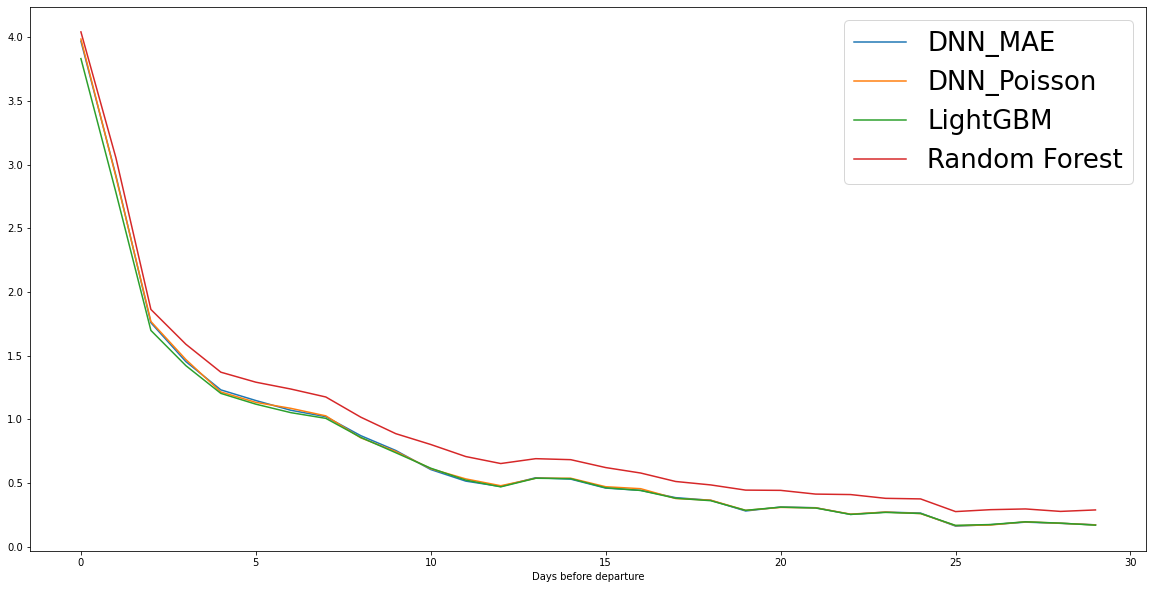

In [321]:
dem_daysbefore_nn = [ np.mean(performance_test[performance_test.days_before_departure.eq(x)].nn_difference) for x in sorted(performance_test.days_before_departure.unique())]
dem_daysbefore_nnp = [ np.mean(performance_test[performance_test.days_before_departure.eq(x)].nnp_difference) for x in sorted(performance_test.days_before_departure.unique())]
dem_daysbefore_lgbm = [ np.mean(performance_test[performance_test.days_before_departure.eq(x)].lgbm_difference) for x in sorted(performance_test.days_before_departure.unique())]
dem_daysbefore_rf = [ np.mean(performance_test[performance_test.days_before_departure.eq(x)].rforest_difference) for x in sorted(performance_test.days_before_departure.unique())]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_nn, label="DNN_MAE")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_nnp, label="DNN_Poisson")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_lgbm, label="LightGBM")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_rf, label="Random Forest")
plt.legend(loc="upper right",prop={'size': 26})

plt.xlabel('Days before departure')
plt.show()

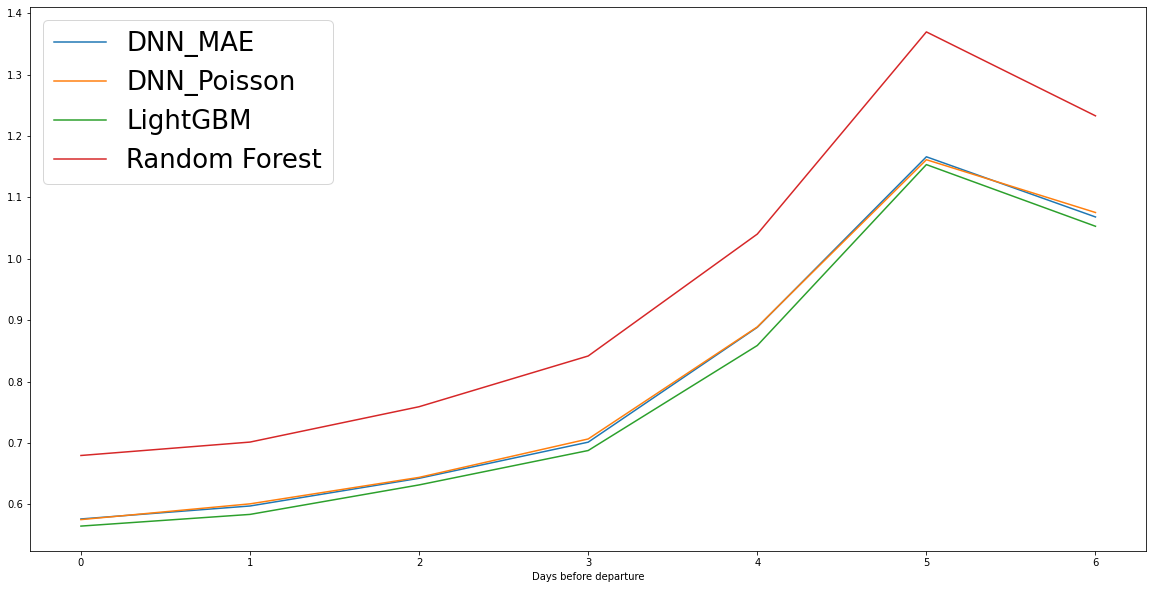

In [322]:
dem_daysbefore_nn = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].nn_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
dem_daysbefore_nnp = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].nnp_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
dem_daysbefore_lgbm = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].lgbm_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
dem_daysbefore_rf = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].rforest_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_nn, label="DNN_MAE")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_nnp, label="DNN_Poisson")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_lgbm, label="LightGBM")
plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_rf, label="Random Forest")
plt.legend(loc="upper left",prop={'size': 26})

plt.xlabel('Days before departure')
plt.show()

In [216]:
dem = performance_test[performance_test.days_before_departure.eq(0)].demand
dem
#np.array(dem)
#int(np.max(dem))

16710      1.0
198210    13.0
199080     5.0
195120    10.0
218400    13.0
          ... 
191850     0.0
140520    22.0
219270     9.0
251130    10.0
266970    12.0
Name: demand, Length: 1928, dtype: float64

(array([277., 232., 197., 142., 257., 192., 168., 111., 108.,  92.,  46.,
         28.,  20.,  20.,   6.,  10.,   8.,   1.,   3.,   2.,   3.,   1.,
          0.,   0.,   4.]),
 array([ 0.  ,  2.72,  5.44,  8.16, 10.88, 13.6 , 16.32, 19.04, 21.76,
        24.48, 27.2 , 29.92, 32.64, 35.36, 38.08, 40.8 , 43.52, 46.24,
        48.96, 51.68, 54.4 , 57.12, 59.84, 62.56, 65.28, 68.  ]),
 <BarContainer object of 25 artists>)

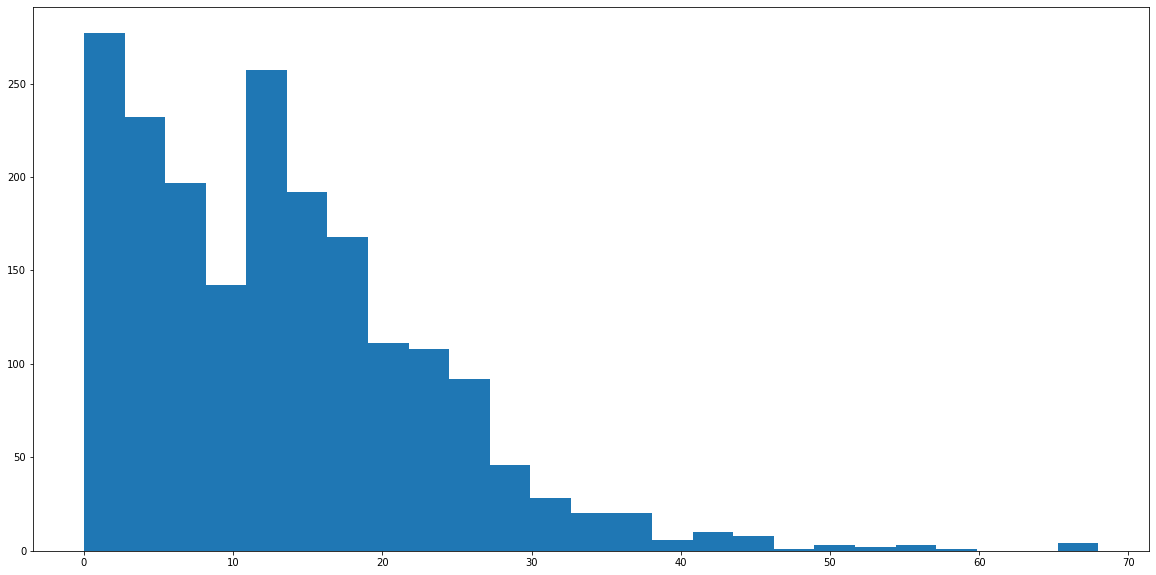

In [217]:
dem_daysbefore_nn = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].nn_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
dem_daysbefore_lgbm = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].lgbm_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
dem_daysbefore_rf = [ np.mean(performance_test[performance_test.od_destination_time_weekday.eq(x)].rforest_difference) for x in sorted(performance_test.od_destination_time_weekday.unique())]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(np.array(dem),bins = 25, range=(0,np.max(dem)))
#plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_lgbm, label="LightGBM")
#plt.plot(range(0,len(dem_daysbefore_nn)),dem_daysbefore_rf, label="Random Forest")
#plt.legend(loc="upper left",prop={'size': 26})

#plt.xlabel('Days before departure')
#plt.show()